In [1]:
##################
# LIBRARY LOADING
##################

import os
import math
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import scipy
from PIL import Image
from scipy import ndimage
from time import gmtime, strftime
from tensorflow.python.framework import ops
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from collections import Counter

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [2]:
#######################
# FUNCTIONS DEFINITION
#######################

# One hot vector conversion
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# Placeholders creation definition fonction 
def create_placeholders(n_H0 = 28, n_W0 = 28, n_C0 = 1, n_y = 10):
    X = tf.placeholder("float", [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder("float", [None, n_y])
    
    return X,Y


# Filters parameters definition fonction
def initialize_parameters():
    
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [5,5,1,32], initializer = tf.compat.v1.keras.initializers.glorot_uniform(seed=0))
    W2 = tf.get_variable("W2", [5,5,32,64], initializer = tf.compat.v1.keras.initializers.glorot_uniform(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters


# Random minibatches definition 
def random_mini_batches(X, Y, mini_batch_size = 128, seed = 0):
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

# Confusion matrix plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




In [3]:
###################
# READINGS OF DATA
###################

# Training data loading
df_train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
train_label = df_train.loc[:,['label']].to_numpy()
train_pict = df_train.drop(['label'], axis = 1).to_numpy()

# Data to submit loading 
df_submit = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
submit_pict = df_submit.to_numpy()

In [4]:
#####################
# MATRICES RESHAPING
#####################

train_pict = train_pict.reshape(-1, 28, 28,1)
submit_pict = submit_pict.reshape(-1, 28, 28,1)
train_label = convert_to_one_hot(train_label,10).T

nb_training_images = 40000
test_pict = train_pict[nb_training_images:-1,:,:,:]
train_pict = train_pict[:nb_training_images,:,:,:]
test_label = train_label[nb_training_images:-1,:]
train_label = train_label[:nb_training_images,:]

print('IMAGES NUMBERS AND SHAPE REVIEW :\n' + '_'*35 + '\n')
print("Images for training : \t\t" + str(np.shape(train_pict)))
print("Images for test : \t\t" + str(np.shape(test_pict)))
print()
print("Labels for training : \t\t" + str(np.shape(train_label)))
print("Labels for test : \t\t" + str(np.shape(test_label)))

IMAGES NUMBERS AND SHAPE REVIEW :
___________________________________

Images for training : 		(40000, 28, 28, 1)
Images for test : 		(1999, 28, 28, 1)

Labels for training : 		(40000, 10)
Labels for test : 		(1999, 10)


In [5]:
########################
# IMAGES AUGMENTATION
########################

train_pict_gene = np.zeros(np.shape(train_pict))
train_label_gene = np.zeros(np.shape(train_label))

for i in range(4):
    for j in range(0, nb_training_images):
        train_pict_gene[j,:,:,:] = tf.keras.preprocessing.image.random_rotation(train_pict[j,:,:,:],rg=1, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.0,interpolation_order=1)
        train_pict_gene[j,:,:,:] = tf.keras.preprocessing.image.random_shift(train_pict_gene[j,:,:,:], wrg=0.1, hrg=0.1, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.0, interpolation_order=1) 
        train_pict_gene[j,:,:,:] = tf.keras.preprocessing.image.random_zoom(train_pict_gene[j,:,:,:], zoom_range=[0.9, 1.1], row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.0, interpolation_order=1)
        train_label_gene[j,:] = train_label[j,:]    
    train_pict = np.append(train_pict, train_pict_gene, axis = 0)
    train_label = np.append(train_label, train_label_gene, axis = 0)
    
print('IMAGES NUMBERS AND SHAPE REVIEW AFTER DATA AUGMENTATION:\n' + '_'*65 + '\n')
print("Images for training : \t\t" + str(np.shape(train_pict)))
print("Images for test : \t\t" + str(np.shape(test_pict)))
print()
print("Labels for training : \t\t" + str(np.shape(train_label)))
print("Labels for test : \t\t" + str(np.shape(test_label)))

IMAGES NUMBERS AND SHAPE REVIEW AFTER DATA AUGMENTATION:
_________________________________________________________________

Images for training : 		(200000, 28, 28, 1)
Images for test : 		(1999, 28, 28, 1)

Labels for training : 		(200000, 10)
Labels for test : 		(1999, 10)


In [6]:
#################
# DATA SHUFFLING 
#################

train_pict, train_label = shuffle(train_pict, train_label, random_state=0)

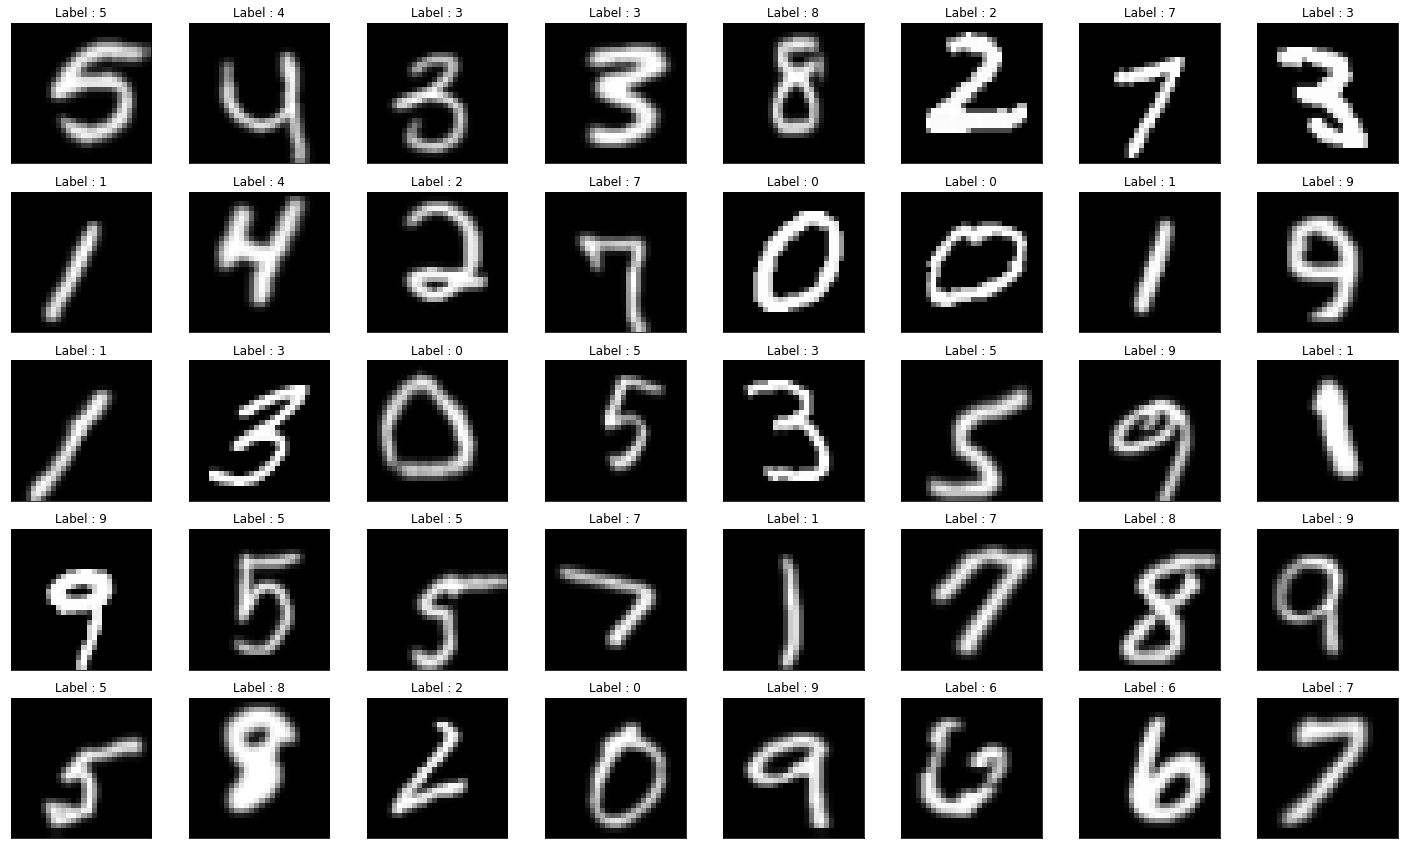

In [7]:
##################
# IMAGES PRINTING
##################

nrows = 5
ncols = 8

fig, axs = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey = True, figsize=(25,15))
axs = axs.flatten()

for i in range(nrows):
    for j in range(ncols):
        axs[i * ncols + j].imshow(train_pict[i * ncols + j,:,:,0], cmap = "gray")
        axs[i * ncols + j].title.set_text("Label : " + str(np.where(train_label[i * ncols + j,:] == np.amax(train_label[i * ncols + j,:]))[0][0]))
        axs[i * ncols + j].set_xticks([])
        axs[i * ncols + j].set_yticks([])        

In [8]:
################
# NORMALIZATION
################

train_pict = train_pict / 255.
test_pict = test_pict / 255.
submit_pict = submit_pict / 255.

In [9]:
X, Y = create_placeholders()

tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1[:,:,0,0] = \n" + str(parameters["W1"].eval()[:,:,0,0]))
    print("W1.shape: " + str(parameters["W1"].shape))
    print("\n")
    print("W2[:,:,0,0] = \n" + str(parameters["W2"].eval()[:,:,0,0]))
    print("W2.shape: " + str(parameters["W2"].shape))
    print("\n")

    


W1[:,:,0,0] = 
[[ 0.05333368  0.06511365  0.07580069 -0.05896769  0.00060841]
 [-0.07178784 -0.05074088 -0.05396143 -0.01129621  0.02181643]
 [ 0.06322698 -0.02270227 -0.06271186  0.02092292 -0.00659628]
 [-0.08256569  0.00298333  0.06035271  0.07769182  0.05418396]
 [ 0.0330904  -0.06162648 -0.05745415 -0.04383402 -0.0586478 ]]
W1.shape: (5, 5, 1, 32)


W2[:,:,0,0] = 
[[ 0.03126964  0.03489425 -0.01219304 -0.02719571  0.00716648]
 [ 0.04382551 -0.03979962 -0.02291467 -0.02305633  0.01625058]
 [-0.03009248  0.02040089  0.01792219 -0.01373746  0.03879795]
 [ 0.0109059   0.01952526 -0.02576062  0.04002028  0.00880301]
 [ 0.03035698  0.04775912  0.03987208  0.00895828  0.00051477]]
W2.shape: (5, 5, 32, 64)




In [10]:
######################
# FORWARD PROPAGATION
######################

def forward_propagation(X, parameters):
 
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    P1 = tf.nn.max_pool(Z1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    P2 = tf.nn.max_pool(Z2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    F3 = tf.layers.Flatten()(P2)
    
    Z3 = tf.keras.layers.Dense(1024, activation=None)(F3)
    A3 = tf.nn.relu(Z3)
    A3 = tf.nn.dropout(A3, rate=0.5, noise_shape=None, seed=None, name=None)
    
    Z4 = tf.keras.layers.Dense(10, activation=None)(A3)
  

    return Z4

In [11]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders()
    parameters = initialize_parameters()
    Z4 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z4, {X: np.random.randn(2,28,28,1), Y: np.random.randn(2,10)})
    print("Z4 = \n" + str(a))

Z4 = 
[[ 0.30464536 -0.03520226 -0.17057997 -0.39002928 -0.3495636   0.435036
   0.34466156 -0.36643127  0.12936741  0.08463593]
 [ 0.07499616 -0.24906316  0.15316474 -0.28545135 -0.38163844 -0.2920495
   0.0922315  -0.22786865  0.4252059   0.34956747]]


In [12]:
#################
# COST COMPUTING 
#################

def compute_cost(Z4, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z4, labels = Y))
    
    return cost

In [13]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders()
    parameters = initialize_parameters()
    Z4 = forward_propagation(X, parameters)
    cost = compute_cost(Z4, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,28,28,1), Y: np.random.randn(4,10)})
    print("cost = " + str(a))

cost = 6.0713863


In [14]:
#################
# MODEL CREATION
#################

def model(X_train, Y_train, X_test, Y_test, X_submit, learning_rate = 0.0001,
          num_epochs = 100, minibatch_size = 128, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders()

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z4 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z4, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer,cost], feed_dict={X:minibatch_X,Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)

        # Calculate the correct predictions
        predict_op = tf.argmax(Z4, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        submit_fake_accuracy = accuracy.eval({X: X_submit, Y: np.zeros((np.shape(submit_pict)[0], 10))})
        print("")
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        print("\n")
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("CNN learning curve")
        plt.show()
        
        # Predictions on the set to submit
        submit_label = predict_op.eval({X: X_submit})
        test_prediction_label = predict_op.eval({X: X_test})
               
        return train_accuracy, test_accuracy, parameters, submit_label, test_prediction_label


In [15]:
##########################
# TRAINING EXAMPLE CHUNK
##########################
num_estimators = 5

train_pict_chunk = np.array_split(train_pict, num_estimators)
train_label_chunk = np.array_split(train_label, num_estimators)

CNN 1 TRAINING :
------------------------------
Cost after epoch 0: 0.836808
Cost after epoch 5: 0.087787
Cost after epoch 10: 0.046005
Cost after epoch 15: 0.026873
Cost after epoch 20: 0.016770
Cost after epoch 25: 0.012676
Cost after epoch 30: 0.008279
Cost after epoch 35: 0.007627
Cost after epoch 40: 0.005411
Cost after epoch 45: 0.005768
Cost after epoch 50: 0.003420
Cost after epoch 55: 0.003730
Cost after epoch 60: 0.003198
Cost after epoch 65: 0.002818
Cost after epoch 70: 0.003014
Cost after epoch 75: 0.002703
Cost after epoch 80: 0.002606
Cost after epoch 85: 0.001632
Cost after epoch 90: 0.003068
Cost after epoch 95: 0.002697

Train Accuracy: 0.999425
Test Accuracy: 0.98749375




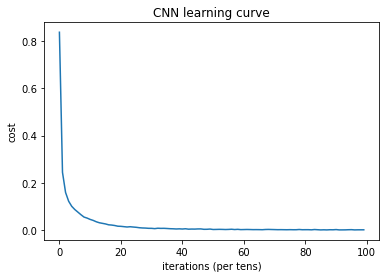

CNN 2 TRAINING :
------------------------------
Cost after epoch 0: 0.842132
Cost after epoch 5: 0.089101
Cost after epoch 10: 0.047849
Cost after epoch 15: 0.028368
Cost after epoch 20: 0.019276
Cost after epoch 25: 0.012585
Cost after epoch 30: 0.009500
Cost after epoch 35: 0.006814
Cost after epoch 40: 0.006632
Cost after epoch 45: 0.005456
Cost after epoch 50: 0.005001
Cost after epoch 55: 0.004165
Cost after epoch 60: 0.002818
Cost after epoch 65: 0.003846
Cost after epoch 70: 0.002620
Cost after epoch 75: 0.002965
Cost after epoch 80: 0.002785
Cost after epoch 85: 0.002406
Cost after epoch 90: 0.002260
Cost after epoch 95: 0.002334

Train Accuracy: 0.999375
Test Accuracy: 0.9884942




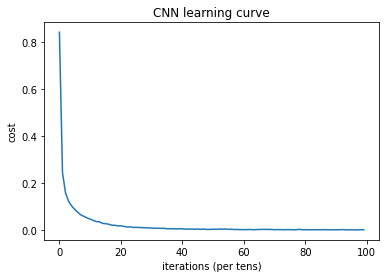

CNN 3 TRAINING :
------------------------------
Cost after epoch 0: 0.836564
Cost after epoch 5: 0.084975
Cost after epoch 10: 0.044463
Cost after epoch 15: 0.027341
Cost after epoch 20: 0.015701
Cost after epoch 25: 0.011664
Cost after epoch 30: 0.008563
Cost after epoch 35: 0.006402
Cost after epoch 40: 0.006029
Cost after epoch 45: 0.005250
Cost after epoch 50: 0.004023
Cost after epoch 55: 0.003950
Cost after epoch 60: 0.003470
Cost after epoch 65: 0.003063
Cost after epoch 70: 0.002559
Cost after epoch 75: 0.002630
Cost after epoch 80: 0.002343
Cost after epoch 85: 0.002110
Cost after epoch 90: 0.002922
Cost after epoch 95: 0.002209

Train Accuracy: 0.99915
Test Accuracy: 0.98749375




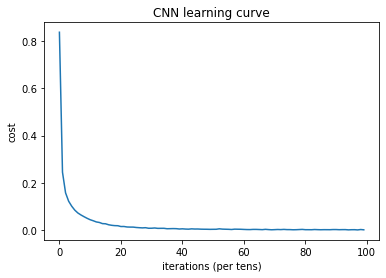

CNN 4 TRAINING :
------------------------------
Cost after epoch 0: 0.840704
Cost after epoch 5: 0.085451
Cost after epoch 10: 0.045339
Cost after epoch 15: 0.026380
Cost after epoch 20: 0.016628
Cost after epoch 25: 0.012977
Cost after epoch 30: 0.009816
Cost after epoch 35: 0.008339
Cost after epoch 40: 0.005125
Cost after epoch 45: 0.005174
Cost after epoch 50: 0.003760
Cost after epoch 55: 0.004896
Cost after epoch 60: 0.002624
Cost after epoch 65: 0.003562
Cost after epoch 70: 0.002756
Cost after epoch 75: 0.003641
Cost after epoch 80: 0.001537
Cost after epoch 85: 0.002898
Cost after epoch 90: 0.002880
Cost after epoch 95: 0.001706

Train Accuracy: 0.9997
Test Accuracy: 0.9869935




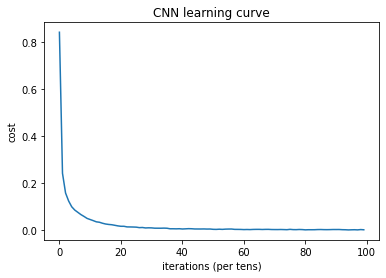

CNN 5 TRAINING :
------------------------------
Cost after epoch 0: 0.840350
Cost after epoch 5: 0.084759
Cost after epoch 10: 0.044498
Cost after epoch 15: 0.026548
Cost after epoch 20: 0.017375
Cost after epoch 25: 0.012762
Cost after epoch 30: 0.008281
Cost after epoch 35: 0.006546
Cost after epoch 40: 0.005452
Cost after epoch 45: 0.005425
Cost after epoch 50: 0.005630
Cost after epoch 55: 0.004185
Cost after epoch 60: 0.003249
Cost after epoch 65: 0.002333
Cost after epoch 70: 0.002037
Cost after epoch 75: 0.002183
Cost after epoch 80: 0.002606
Cost after epoch 85: 0.002148
Cost after epoch 90: 0.002095
Cost after epoch 95: 0.002108

Train Accuracy: 0.999475
Test Accuracy: 0.9889945




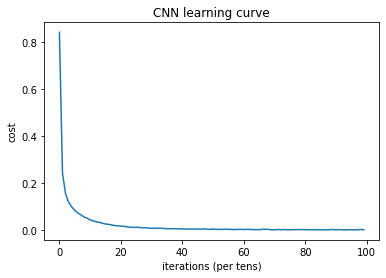

In [16]:
submitted_votes = np.zeros((np.shape(submit_pict)[0],num_estimators))

for i in range(num_estimators):
    print("CNN " + str(i+1) + " TRAINING :")
    print("-"*30)
    _, _, parameters, submit_label, test_prediction_label = model(train_pict_chunk[i], train_label_chunk[i], test_pict, test_label, submit_pict)
    submitted_votes[:,i] = submit_label
        

In [17]:
##################################
# SUBMISSIONS BASED ON CNNs VOTES
##################################

for i in range(np.shape(submit_label)[0]):
    submit_label[i] = Counter(submitted_votes[i]).most_common(1)[0][0].astype(int)

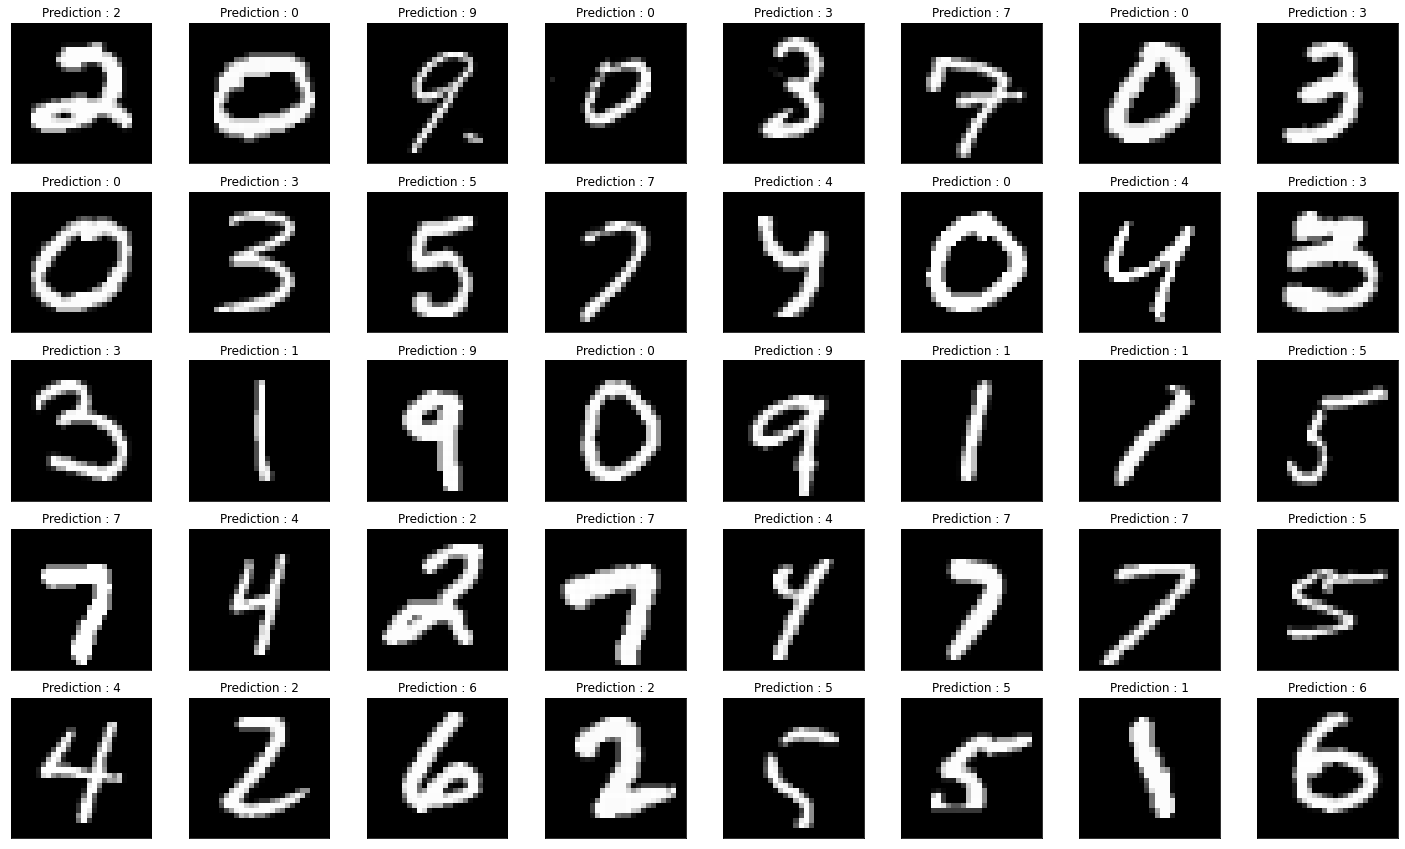

In [18]:
############################
# PREDICTED LABELS PRINTING
############################
  
nrows = 5
ncols = 8

fig, axs = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey = True, figsize=(25,15))
axs = axs.flatten()

for i in range(nrows):
    for j in range(ncols):
        axs[i * ncols + j].imshow(255. * submit_pict[i * ncols + j,:,:,0], cmap = "gray")
        axs[i * ncols + j].title.set_text("Prediction : " + str(submit_label[i * ncols + j]))
        axs[i * ncols + j].set_xticks([])
        axs[i * ncols + j].set_yticks([])            

In [19]:
#########################
# PREDICTIONS SUBMISSION
#########################

ImageId = np.arange(start=1, stop=1 + np.shape(submit_label)[0], step=1)
df_2_submit = pd.DataFrame({'ImageId': ImageId,'Label':submit_label})
df_2_submit.to_csv('/kaggle/working/' + 'submission' + strftime("%Y-%m-%d_%H:%M", gmtime()) + '.csv', index = False)


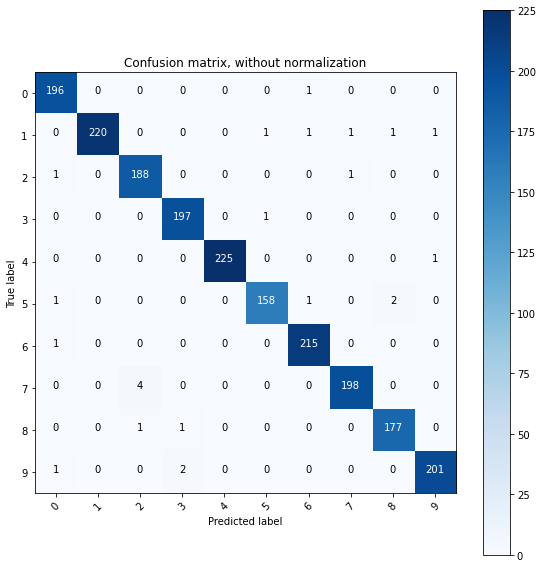

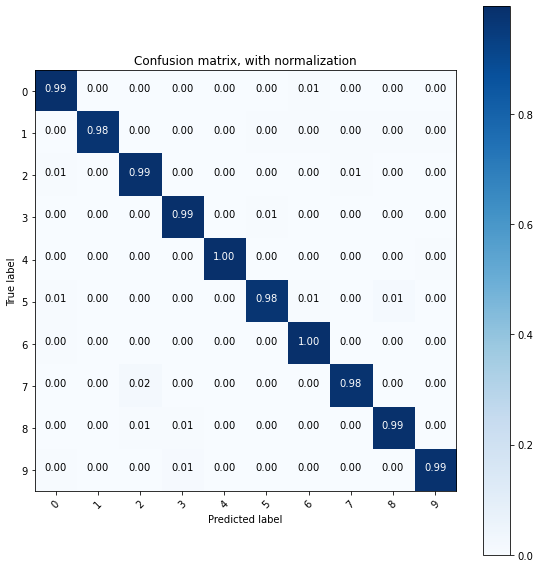

In [20]:
##############################################################
# MISCLASSIFIED PREDICTIONS TROUBLESHOOTING ON VALIDATION SET
##############################################################

test_label = df_train.loc[:,['label']].to_numpy()[nb_training_images:-1,:].reshape(np.shape(test_prediction_label))

cnf_matrix = confusion_matrix(test_label, test_prediction_label, labels=[0,1,2,3,4,5,6,7,8,9])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (8, 8))
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8,9], title='Confusion matrix, without normalization')

plt.figure(figsize = (8, 8))
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8,9], normalize=True, title='Confusion matrix, with normalization')